In [1]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2

--2019-05-04 23:33:22--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  18.2MB/s    in 86s     

2019-05-04 23:34:49 (13.8 MB/s) - ‘RML2016.10b.tar.bz2’ saved [1245608913/1245608913]



In [0]:
import tarfile
tar = tarfile.open("RML2016.10b.tar.bz2", "r:bz2")
tar.extractall()
tar.close()

In [0]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import pickle
import keras.models as models

from keras.layers import BatchNormalization
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.core import Dense, Reshape, Flatten, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn import preprocessing

In [0]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("RML2016.10b.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
dataset = []  
data_labels = []
for mod in mods:
    for snr in snrs:
        dataset.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  data_labels.append((mod,snr))
dataset = np.vstack(dataset)

In [8]:
print("dataset size = %d" % len(dataset))
print("number of features for each instance = %d" % len(dataset[0]))
print("number of elements in each feature = %d" % len(dataset[0][0]))

dataset size = 1200000
number of features for each instance = 2
number of elements in each feature = 128


## Split the data into 50% for training/validation and 50% for testing.

In [9]:
training_data, test_data, training_labels_snrs, test_labels_snr = train_test_split(dataset, data_labels, test_size = 0.5, random_state = 42, stratify = data_labels)

training_labels = [label[0] for label in training_labels_snrs]
test_labels = [label[0] for label in test_labels_snr]

print("training data size: %d" % len(training_data))
print("test data size: %d" % len(test_data))
print("training data labels size: %d" % len(training_labels))
print("test data labels size: %d" % len(test_labels))

training data size: 600000
test data size: 600000
training data labels size: 600000
test data labels size: 600000


In [11]:
del(dataset)
gc.collect()

162

In [0]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(training_labels)
training_labels = label_binarizer.transform(training_labels)

label_binarizer.fit(test_labels)
test_labels = label_binarizer.transform(test_labels)

In [12]:
test_labels[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
print(test_labels[0])

[0 1 0 0 0 0 0 0 0 0]


## Build the Convolutional Neural Network

In [14]:
cnn_model = models.Sequential([
    
    Reshape([1, 2, 128], input_shape = (2, 128)),
    
    Convolution2D(activation="relu", padding = 'same', data_format="channels_first", filters=64, kernel_size=(1, 3)),
    
    Convolution2D(activation="relu", padding = 'same', data_format="channels_first", filters=16, kernel_size=(2, 3)),
    
    Flatten(),
    
    Dense(units=128, activation="relu"), 
    
    Dense(units=10, activation="softmax")
    
])

cnn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
cnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 2, 128)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 2, 128)        6160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 532,122
Trainable params: 532,122
Non-trainable params: 

In [15]:
fitting_progress = cnn_model.fit(training_data, training_labels, epochs=100,
              batch_size=512, validation_split= 0.01,
              callbacks=[
                  EarlyStopping(patience=5, monitor = 'val_loss', mode = 'min'),
                  ModelCheckpoint("cnn-best-model.hdf5", monitor='val_loss', save_best_only=True, mode='min', period=1)
              ])

Instructions for updating:
Use tf.cast instead.
Train on 594000 samples, validate on 6000 samples
Epoch 1/100
594000/594000 [==============================] - 15s 25us/step - loss: 1.6681 - acc: 0.3342 - val_loss: 1.3681 - val_acc: 0.4400
Epoch 2/100
594000/594000 [==============================] - 12s 20us/step - loss: 1.2771 - acc: 0.4736 - val_loss: 1.2491 - val_acc: 0.4845
Epoch 3/100
594000/594000 [==============================] - 12s 20us/step - loss: 1.2126 - acc: 0.4957 - val_loss: 1.1934 - val_acc: 0.5007
Epoch 4/100
594000/594000 [==============================] - 12s 20us/step - loss: 1.1720 - acc: 0.5089 - val_loss: 1.1661 - val_acc: 0.5128
Epoch 5/100
594000/594000 [==============================] - 12s 20us/step - loss: 1.1445 - acc: 0.5195 - val_loss: 1.1524 - val_acc: 0.5150
Epoch 6/100
594000/594000 [==============================] - 12s 20us/step - loss: 1.1251 - acc: 0.5286 - val_loss: 1.1416 - val_acc: 0.5138
Epoch 7/100
594000/594000 [=============================

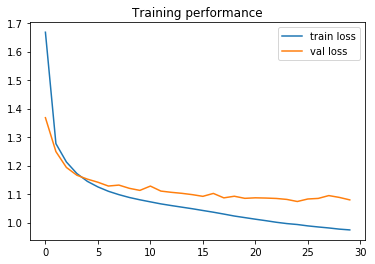

In [16]:
plt.figure()
plt.title('Training performance')
plt.plot(fitting_progress.epoch, fitting_progress.history['loss'], label='train loss')
plt.plot(fitting_progress.epoch, fitting_progress.history['val_loss'], label='val loss')
plt.legend()

In [0]:
cnn_best_model = load_model('cnn-best-model.hdf5')

In [18]:
score = cnn_best_model.evaluate(test_data, test_labels)
print(score)

600000/600000 [==============================] - 32s 53us/step
[1.0706044343916574, 0.5565016666666667]


In [19]:
score = cnn_model.evaluate(test_data, test_labels)
print(score)

600000/600000 [==============================] - 31s 51us/step
[1.0781004560295742, 0.5578366666666666]


In [0]:
test_predicted_labels = cnn_best_model.predict(test_data, batch_size = 512)

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

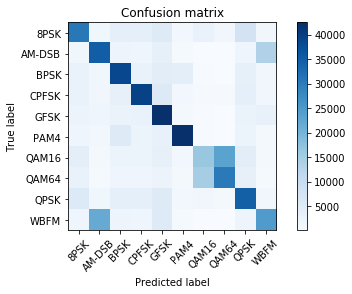

In [22]:
confusion_matrix = np.zeros([10,10])
for i in range(len(test_data)):
    true_label_indx = list(test_labels[i]).index(1)
    predicted_label_indx = np.argmax(test_predicted_labels[i])
    confusion_matrix[true_label_indx,predicted_label_indx] += 1

plot_confusion_matrix(confusion_matrix, labels = mods)

In [0]:
mods_snrs = np.array(test_labels_snr)
snrs = mods_snrs[:,1]
unique_snrs = sorted(set(mods_snrs[:,1]), key = int)

Overall Accuracy: 0.105367
Overall Accuracy: 0.108300
Overall Accuracy: 0.114567
Overall Accuracy: 0.139733
Overall Accuracy: 0.188033
Overall Accuracy: 0.269867
Overall Accuracy: 0.366067
Overall Accuracy: 0.474300
Overall Accuracy: 0.592100
Overall Accuracy: 0.690167
Overall Accuracy: 0.764867
Overall Accuracy: 0.795633
Overall Accuracy: 0.806667
Overall Accuracy: 0.814600
Overall Accuracy: 0.816500
Overall Accuracy: 0.815367
Overall Accuracy: 0.817833
Overall Accuracy: 0.814567
Overall Accuracy: 0.816567
Overall Accuracy: 0.818933


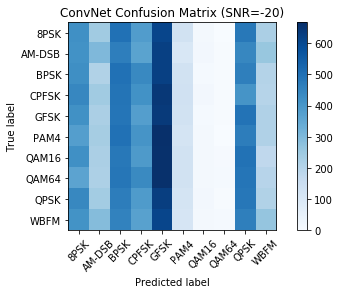

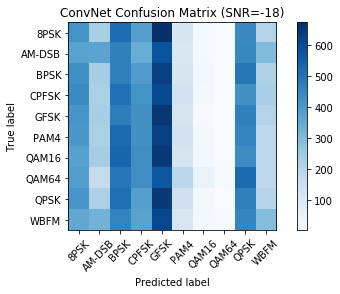

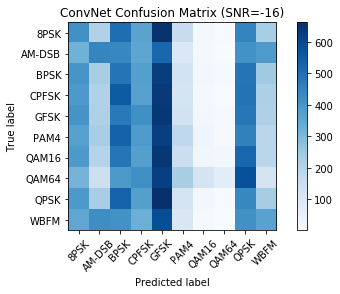

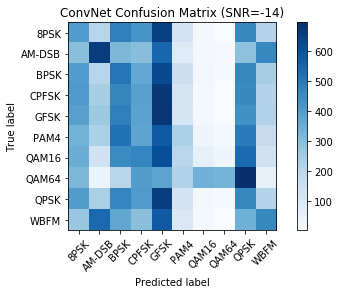

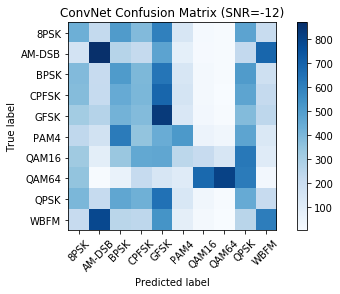

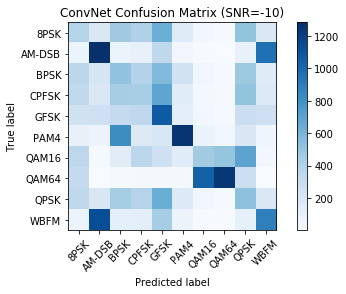

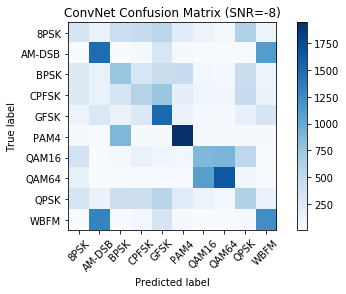

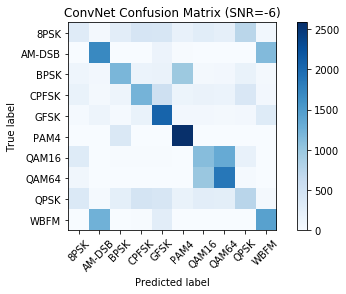

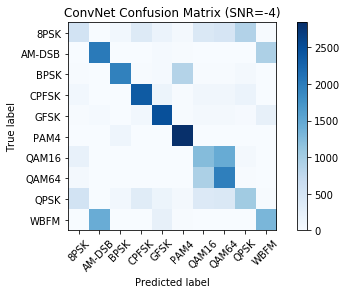

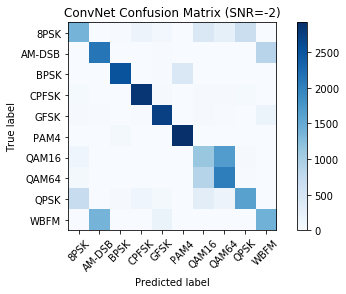

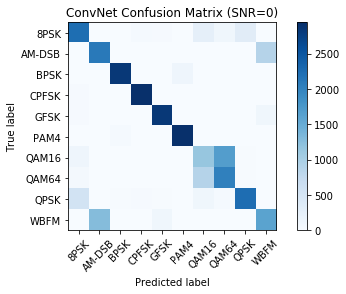

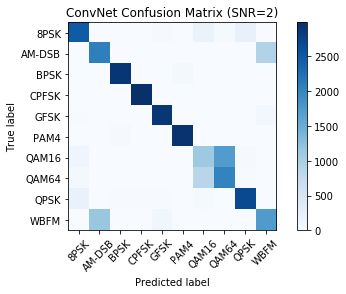

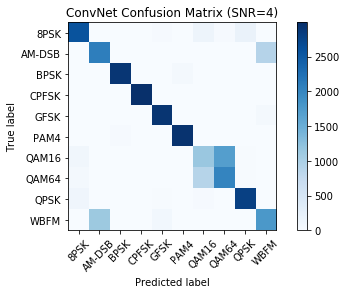

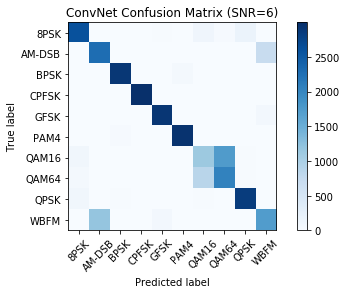

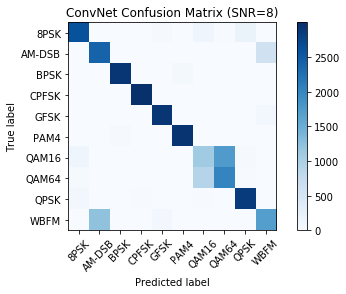

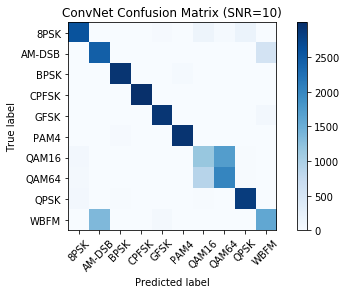

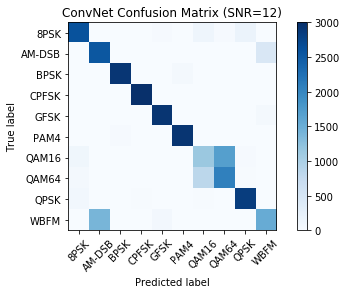

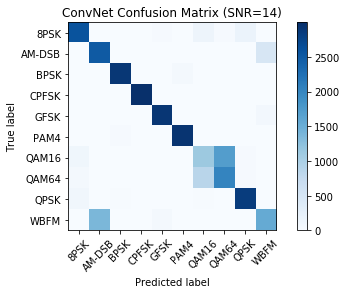

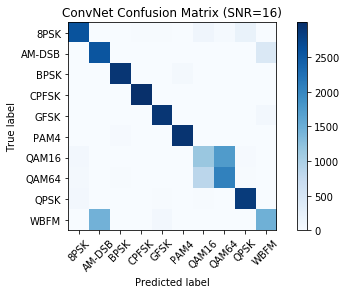

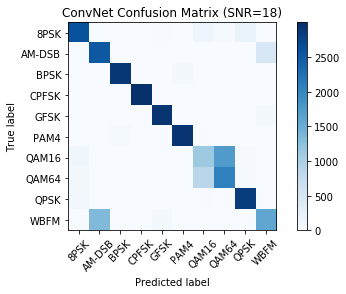

In [37]:
acc = []
for snr in unique_snrs:

    snr_points_indx = np.where(snrs == snr)[0]
  
    snr_test_data = test_data[snr_points_indx]
    
    snr_test_labels = test_labels[snr_points_indx]    
   
    snr_test_predicted_labels = cnn_best_model.predict(snr_test_data, batch_size = 512)
    
    confusion_matrix = np.zeros([10,10])
    for i in range(len(snr_test_data)):
        true_label_indx = list(snr_test_labels[i]).index(1)
        predicted_label_indx = np.argmax(snr_test_predicted_labels[i])  
        confusion_matrix[true_label_indx,predicted_label_indx] += 1

    plt.figure()
    plot_confusion_matrix(confusion_matrix, labels=mods, title="ConvNet Confusion Matrix (SNR=%s)"%(snr))
    
    correct = np.sum(np.diag(confusion_matrix))
    noncorrect = np.sum(confusion_matrix) - correct
    print("Overall Accuracy: %f" % (correct / (correct + noncorrect)))
    acc.append(1.0*correct / (correct + noncorrect))

Text(0.5,1,'Accuracy agnist SNR')

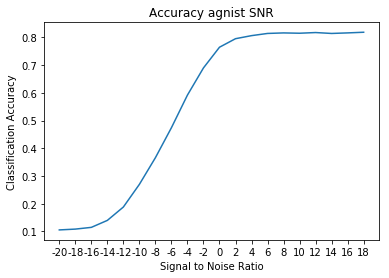

In [38]:
# Plot accuracy curve
plt.plot(list(unique_snrs), acc) 
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy agnist SNR")